### Cliff walking
1. 문제: 12x4 격자로 이루어진 판 위의 특정 환경(절벽)에서 이동할 때 최적의 policy, value function을 **Sarsa, Q-learning**을 통해 구하고 비교해보자.
2. 조건
    - state: 말의 위치
    - action: 상,하,좌,우
    - reward: 이동(-1), 목적지 도달(0), 절벽으로 추락(-100)
3. 학습 목표
    - Sarsa
    - Q-learning 
    - 위 학습 방법들 간의 특징에 의한 차이점 확인 

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import count

#### Cliff walking
- 아래 그림에서와 같이 아래 부분에 절벽이 존재하며 도달 시에 큰 패널티가 부여된다. 
- 출발 지점(S)와 도착 지점(G)가 정해져 있다.  

![cliff walking](../images/cliff_walking.png)
<center> 출처: Reinforcement Learning : An Introduction. Richard S. Sutton and Andrew G. Barto. 2017 (pp. 108) </center>

In [6]:
START = 36
END = 47
WORLD_WIDTH = 12
WORLD_HEIGHT = 4
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3

class CliffWalking:
    def __init__(self):        
        grid = np.zeros([WORLD_HEIGHT, WORLD_WIDTH])
        self.nA = 4
        self.nS = np.prod(grid.shape)
        it = np.nditer(grid, flags=['multi_index'])
        P = defaultdict(lambda: [[] for i in range(self.nA)])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            s_up = s - WORLD_WIDTH if y != 0 else s 
            s_down = s + WORLD_WIDTH if y != 3 else s 
            s_left = s - 1 if x != 0 else s
            s_right = s + 1 if x != 11 else s 
        
            if y == 3 and 1 <= x <= 10:
                P[s][UP] = P[s][DOWN] = P[s][LEFT] = P[s][RIGHT] = [1.0, START, -100, False]
            elif s == END:
                P[s][UP] = P[s][DOWN] = P[s][LEFT] = P[s][RIGHT] = [1.0, s, 0, True]
            else:
                P[s][UP] = [1.0, s_up, -1, False]
                P[s][DOWN] = [1.0, s_down, -1, False]
                P[s][LEFT] = [1.0, s_left, -1, False]
                P[s][RIGHT] = [1.0, s_right, -1, False]
                
            it.iternext()
        self.P = P
    
    def reset(self):
        self.state = START
        return self.state
    
    def step(self, action): 
        prob, next_state, reward, done = self.P[self.state][action] 
        self.state = next_state 
        return prob, next_state, reward, done 

#### Epsilon greedy policy 
Exploration을 위해 일정한 확률(주로 낮은) $\epsilon$로 모든 action 중에 무작위로 선택하도록 한다.

$\pi(a \lvert s) \leftarrow \left\{
            \begin{array}{ll}
              1 - \epsilon + \epsilon/ \lvert \mathcal{A}(s) \rvert \text{ if } a = A^{\ast}\\
              \epsilon/ \lvert \mathcal{A}(s) \rvert \text{ if } a \neq A^{\ast}
            \end{array}
        \right.$

In [7]:
def epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        policy = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        policy[best_action] += 1.0 - epsilon
        return policy
    return policy_fn

#### Sarsa
현재 time step($t$)에서의 state($S_t$), action($A_t$)와 다음 time step($t+1$)에서의 state($S_{t+1}$), action($A_{t+1}$), reward($R_{t+1}$)을 고려해서 최적의 action-value function($Q$)을 찾는 방법을 **Sarsa** 라고 한다.

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big [ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \big ]$

In [8]:
def sarsa(env, num_episodes, policy_fn, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = np.zeros([env.nS, env.nA])
    policy = policy_fn(Q, epsilon, env.nA)
    counter = [0]
    rewards = []
    for i_episode in range(num_episodes):
        state = env.reset()
        rewards.append(0)
        for t in count(): 
            action = np.random.choice(env.nA, p=policy(state))
            prob, next_state, reward, done = env.step(action)
            rewards[-1] += reward
            next_action = np.random.choice(env.nA, p=policy(next_state))
            Q[state][action] += alpha * (reward + discount_factor * \
                                         Q[next_state][next_action] - Q[state][action])
            if done:
                counter.append(counter[-1] + t + 1)
                break
            state = next_state
            action = next_action 
    return Q, counter, rewards

In [9]:
env = CliffWalking()
Q_sarsa, counter_sarsa, rewards_sarsa = sarsa(env, 1000, epsilon_greedy_policy)

### Q-Learning: Off-policy TD Control
Q-learning은 TD control 알고리즘을 off-policy learning으로 학습하는 것으로 볼 수 있다. **off-policy**는 action을 sampling할 때의 behavior policy와 학습할 때 목표가되는  target policy가 다른 경우를 의미한다. 

Q-learning에서 target policy는 $\underset a {\max}Q(S_{t+1}, a)$, optimal action을 갖고 behavior policy는 $Q$로부터 $\epsilon$-greedy한 action을 갖는다. (*Importance sampling을 하지 않는 off-policy 방법이다.*)

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \big [ R_{t+1} + \gamma \underset a {\max} Q(S_{t+1}, a) - Q(S_t, A_t) \big ]$


In [10]:
def q_learning(env, num_episodes, policy_fn, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    Q = np.zeros([env.nS, env.nA])
    policy = policy_fn(Q, epsilon, env.nA)
    counter = [0]
    rewards = []
    for i_episode in range(num_episodes):
        state = env.reset()
        rewards.append(0)
        for t in count():    
            action = np.random.choice(env.nA, p=policy(state))
            prob, next_state, reward, done = env.step(action)
            rewards[-1] += reward
            Q[state][action] += alpha * (reward + discount_factor * max(Q[next_state])\
                                         - Q[state][action])
            if done:
                counter.append(counter[-1] + t + 1)
                break 
            state = next_state
    return Q, counter, rewards

In [11]:
Q_q, counter_q, rewards_q = q_learning(env, 1000, epsilon_greedy_policy)

In [12]:
rewards_sarsa = [max(i, -100) for i in rewards_sarsa]
rewards_q = [max(i, -100) for i in rewards_q]

In [13]:
smoothedrewards_sarsa = np.copy(rewards_sarsa)
smoothedrewards_q = np.copy(rewards_q)
for i in range(10, 1000):
    smoothedrewards_sarsa[i] = np.mean(rewards_sarsa[i - 10: i + 1])
    smoothedrewards_q[i] = np.mean(rewards_q[i - 10: i + 1])

#### 학습 속도 비교 
비슷한 속도로 학습이 되며 Q-learning이 조금 더 빠른 것을 볼 수 있다.

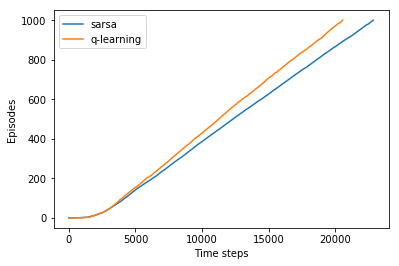

In [14]:
plt.plot(counter_sarsa, np.arange(len(counter_sarsa)),label='sarsa')
plt.plot(counter_q, np.arange(len(counter_sarsa)), label='q-learning')
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.legend()
plt.show()

#### Figure 6.4
Q-learning이 Sarsa와 비교했을 때 더 risky 하게 cliff에 붙어서 이동하기 때문에 펴여균적인 reward가 낮은 것을 볼 수 있다. (*책의 그래프에 비해 smooth 하지 않은 차이가 있는데 책에서는 10번 수행한 결과를 평균내서 그렇다.*)

그 이유는 sarsa의 경우에는 on-policy로 target, behavior policy를 같이 다루기 때문에 cliff에 빠질 경우 이를 학습해서 돌아가지 않는 방향으로 학습한다. 하지만 Q-learning의 경우에는 target policy를 max로 가져가기 때문에 현재 상태에서 cliff에 빠지더라도 계속해서 최적의 길로 가려고 한다. (*계속 빠진다.*)

(-100, 0)

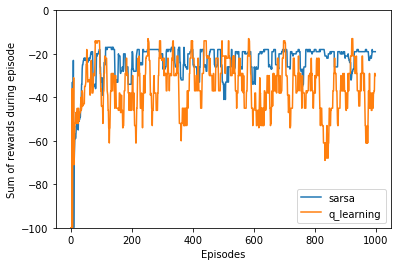

In [15]:
plt.plot(smoothedrewards_sarsa, label = 'sarsa')
plt.plot(smoothedrewards_q, label = 'q_learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()
plt.show()

최종적으로 두 학습 방법이 다른 optimal action을 갖는 것을 확인할 수 있다.
- Sarsa: cliff에 떨어져서 이동한다.
- Q-learning: cliff에 붙어서 이동한다. 

In [13]:
def render(Q):
    for j, i in enumerate(np.argmax(Q, axis=1)):
        if i == 0:
            print('^', end=',')
        elif i == 1:
            print('v', end=',')
        elif i == 2:
            print('<', end=',')
        else:
            print('>', end=',')
        if (j + 1) % 12 == 0:
            print('\n')

In [14]:
print("Q_learning: 500 steps")
render(Q_q)
print("Sarsa: 500 steps")
render(Q_sarsa)

Q_learning: 500 steps
>,>,<,>,^,>,>,>,>,v,v,v,

>,v,>,>,>,>,>,v,v,>,v,v,

>,>,>,>,>,>,>,>,>,>,>,v,

^,^,<,v,v,^,v,^,>,<,>,^,

Sarsa: 500 steps
>,>,>,>,>,>,>,>,>,>,v,v,

>,>,>,>,>,>,>,>,^,^,>,v,

^,^,^,^,^,^,^,^,<,^,>,v,

^,^,>,^,>,v,>,v,^,>,v,^,

